# Foundation of Deep Learning programming exercise 1

In this exercise, we will run an SGD code on a simple neural work and examine the convergence of the weight parameters. 
Part of the codes in this notebook has been written for you; and part of them will be filled up by you. After each question in the markdown cell, replace the blank in the code cell by a correct code and delete the first # sign in the line.

In [386]:
# import packages
import numpy as np
import torch as th
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid #sigmoid function as activation function
import IPython
print("packages imported.")

packages imported.


## I. Load Dataset 
The following dataset includes 10 features like age, sex, body mass index,... obtained for diabetes patients in baseline, as well as the response of interest, a quantitative measure of disease progression one year after baseline.
Note that each of these feature variables have been mean centered and rescaled.

In [387]:
diabetes=load_diabetes() # load dataset
X=diabetes['data'].astype(np.float32) #inpout
Y=diabetes['target'].astype(np.float32) #output
X_th=th.from_numpy(X)
Y_th=th.from_numpy(Y)

1. How many features and samples are there?  Hint: Use the .shape function. 

In [388]:
# Question 1
#################################
# I'm not sure what is meant with number of features. 
# Is it 10 features per sample as stated in the text above or do you mean the amount of features from all samples combined? 
# First case is X.shape[1] = 1 the other case is X.shape[1] * X.shape[2] = 10 * 442 = 4420
d_in = X.shape[1] #number of features = 10
n = X.shape[0] #number of samples = 442

d_in, n



(10, 442)

## II. Define Loss Function
We define the loss function to be the mean square error (MSE):
$$ \ell(\mathbf{y}_\text{pred},\mathbf{y}) := \frac1N \|\mathbf{y}_\text{pred}-\mathbf{y}\|_2^2 $$
where $\mathbf{y} \in \mathbb{R}^n$ is the output vector and $\mathbf{y}_\text{pred}$ its prediction. 

2. Define the loss function below.

In [389]:
# Question 2
#################################

def np_mse_loss(y_pred,y,n):
  return np.square(np.linalg.norm(y_pred - y, 2))/n

There is a built-in function for MSE in Pytorch. Let's check if the answer in Question 2 is correct by running the code:

In [390]:
# Question 2 verification
#################################

th_mse_loss=th.nn.MSELoss()
test_vector_1 = th.rand(n)
test_vector_2 = th.rand(n)
check = (np_mse_loss(test_vector_1,test_vector_2,n) == th_mse_loss(test_vector_1,test_vector_2))
if check == 1:
    print("Definition of MSE is correct.")
else:
    print("Definition of MSE is incorrect. Please redo Question 2 again.")
    print("This could be a rounding error. Please rerun the code a few times too see that it is correct")
print(np_mse_loss(test_vector_1,test_vector_2,n))
print(th_mse_loss(test_vector_1,test_vector_2).item())


Definition of MSE is correct.
0.15670924812420461
0.15670925378799438


## III. Define MLP
Here we define the same shallow neural network (with initialization) in PyTorch and Numpy respectively. 

In [391]:
# PyTorch
class th_MLP(th.nn.Module):
    def __init__(self,h,d):
        super(th_MLP, self).__init__()
        self.theta = th.nn.Linear(d, h,bias=False) #h = width of layer
        self.beta = th.nn.Linear(h, 1,bias=False)
        self.act=th.nn.Sigmoid()
    def forward(self, x):
        return self.beta(self.act(self.theta(x))).squeeze(-1)

# Numpy
class np_MLP():
    def __init__(self,h,d,th_model):
        super(np_MLP, self).__init__()
        self.theta = th_model.theta.weight.detach().numpy() # we copy the weights to have the exact same model!
        self.beta= th_model.beta.weight.detach().numpy() # 
    def forward(self, x):
        return np.dot(self.beta,sigmoid(np.dot(self.theta,x)))

In [392]:
# MLP verification
#################################

h,d=25,d_in
th_model=th_MLP(h,d)
y_pred_th=th_model.forward(X_th)

np_model=np_MLP(h,d,th_model)
y_pred_np=np_model.forward(X.T)

print(f"Prediction shape {y_pred_np.shape}")
print(" ")
print(f"Numpy loss: {np_mse_loss(y_pred_np,Y,n)}")
print(f"Torch loss: {th_mse_loss(y_pred_th,Y_th).item()}")

Prediction shape (1, 442)
 
Numpy loss: 29204.592760180996
Torch loss: 29204.58984375


# IV. Define Gradient
In order to do SGD, first we need to compute the derivative of the Sigmoid function: $\sigma'(x)$ where $\sigma(x):= \frac{1}{1+e^{-x}}$.

3. Define the derivative of the Sigmoid function. Hint: You can use the pre-defined Sigmoid function $\backslash\texttt{sigmoid(x)}$ in the expression of $\sigma'(x)$.

In [393]:
# Question 3
#################################

def sigmoid_prime(x): #partial derivative of Sigmoid
    return sigmoid(x)*(1-sigmoid(x))

The gradient of the weights has been defined for you. 

In [394]:
def l_prime(y_pred,y): #partial derivative of MSE
    return -2*(y-y_pred)  # [1 x n] 

def np_mse_grad_beta(x,y_pred,y,n): # total derivative output weights
    return 1/n*np.dot(sigmoid(np.dot(np_model.theta,x.T)),l_prime(y_pred,y).T) # [1 x h]

def np_mse_grad_theta(x,y_pred,y,n): # total derivative input weights
    theta_x=np.dot(np_model.theta,x.T) # [h x n]
    phi_prime=sigmoid_prime(theta_x) # [h x n]
    return 1/n*np.dot(np.outer(np_model.beta,l_prime(y_pred,y))*phi_prime,x) # [d x h]

In [395]:
#PyTorch: Autodifferentiation
loss=th_mse_loss(y_pred_th,Y_th)
grad_beta=th.autograd.grad(loss,th_model.beta.weight,retain_graph=True)
grad_theta=th.autograd.grad(loss,th_model.theta.weight)

In [396]:
# Question 3 verification
#################################

print(np.allclose(np_mse_grad_beta(X,y_pred_np,Y,n).T,grad_beta[0].numpy()))
print(np.allclose(np_mse_grad_theta(X,y_pred_np,Y,n),grad_theta[0].numpy()))

True
True


# V. SGD

Now we run SGD on the loss function and train the network.

In [397]:
# Define number of steps and learning rate
#################################

steps,lr=700,0.0105 

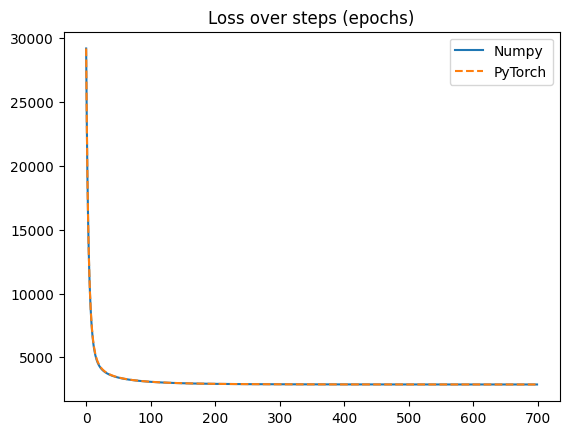

In [398]:
losses_np,losses_th=[],[]
optimizer = th.optim.SGD(th_model.parameters(), lr=lr) 

for k in range(steps):
    # numpy
    y_pred_np=np_model.forward(X.T)
    losses_np.append(np_mse_loss(y_pred_np,Y,n))
    np_model.beta=np_model.beta-lr*np_mse_grad_beta(X,y_pred_np,Y,n).T
    np_model.theta=np_model.theta-lr*np_mse_grad_theta(X,y_pred_np,Y,n)

    # torch
    y_pred_th=th_model.forward(X_th)
    loss = th_mse_loss(y_pred_th, Y_th)
    losses_th.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

plt.plot(losses_np,label="Numpy")
plt.plot(losses_th,label="PyTorch",linestyle='dashed')
plt.title("Loss over steps (epochs)")
plt.savefig("./convergence.svg", format="svg")
plt.legend()

Do you see a convergence curve in the plot? What happens if we change the number of steps and learning rate?